In [ ]:
# default_exp funcs.routines

In [ ]:
%load_ext autoreload
%autoreload 2

# Visualization tools 

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.visualization import *
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.funcs.output_trafo import *
from decode_fish.engine.point_process import PointProcessUniform
import h5py

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def get_df_from_hdf5(group):
    
    df = DF()
    for k in group.keys():
        df[k] = group[k][()]
    return df

def add_df_to_hdf5(parent, name, df):
    
    g = parent.create_group(name)
    for k in df.keys():
        g.create_dataset(k, data=df[k].values)

In [ ]:
#export
def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z).sample()
            xsim = micro(*sim_vars)
            x = micro.noise(xsim, background).sample()

            xsim_col.append(x)
            gt_vars = sim_vars[:-1]
            gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])
            gt_df = gt_df[gt_df['ch_idx'] ==0]
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True, min_int=-100)
            pred_dfs.append(pred_df)
            x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df, matches

def get_reconstruction_from_df(df, micro, output_shape, px_size_zyx=[100,100,100]):
    
    output_shape = torch.Size([1]*(5-len(output_shape))+list(output_shape))
    locs, x, y, z, ints = df_to_micro(df, px_size_zyx)
    rec_img = micro(locs, x, y, z, ints, output_shape)   
    return rec_img


In [ ]:
# xsim, gt = sim_data(decode_dl, 10, micro)
# perf, pred_df, matches = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

# plt.scatter(matches['int_tar'], matches['int_pred'])
# plt.plot([0,10],[0,10])

In [ ]:
#export
def filt_perc(df, perc = 90, return_low=True, metric='comb_sig'):
    if perc >= 100:
        return df
    ret_df = DF()
    for f in df['frame_idx'].unique():
        frame_df = df[df['frame_idx']==f]
        m = frame_df[metric].copy()
        if return_low:
            filt_val = np.percentile(m, perc)
            frame_df = frame_df[m < filt_val]
        else:
            filt_val = np.percentile(m, 100-perc)
            frame_df = frame_df[m > filt_val]            
        ret_df = ret_df.append(frame_df)
    return ret_df

In [ ]:
def int_hist_nnnew(df, micro):
    ints = df['int']#*micro.int_sig.item() + micro.int_mu.item() - micro.int_mu.item() * micro.min_fac
    dist_samp = cpu(torch.distributions.Gamma(model.int_dist.int_conc.item(), model.int_dist.int_rate.item()).sample([10000]))+model.int_dist.int_loc.item()

    max_bin = dist_samp.max()
    print(ints.min())
    _ = plt.hist(ints, bins=np.linspace(0,max_bin,101), density=True, label='Predictions')
    _ = plt.hist(dist_samp, density=True, bins=np.linspace(0,max_bin,101), alpha=0.5, label='Distr.')
    plt.plot([model.int_dist.int_loc.item(),model.int_dist.int_loc.item()],[0,1], color='red')
    plt.title(ints.mean())
    plt.legend()
    
def psf_rmse(psf1, psf2):
    return np.sqrt(np.mean((psf1-psf2)**2))

def psf_corr(psf1, psf2):
    return np.corrcoef(psf1.reshape(-1), psf2.reshape(-1))[0,1]

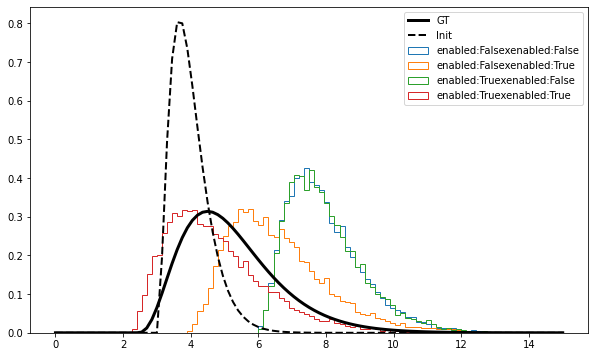

In [ ]:
import scipy.stats as stats  

plt.figure(figsize=(10,6))

#Fit parameters: 
shape = 3.833, 
scale = 0.7328
locaction = 2.421

# files = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_ff18/*/train.yaml'))
files = sorted(glob.glob(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig9/*/train.yaml'))
cfg = OmegaConf.load(files[0])
model = hydra.utils.instantiate(cfg.model)

x = np.linspace(0,15,101)

for f in files[:]:
#     cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fd1/int_mu:{m}//train.yaml')
    cfg = OmegaConf.load(f)
    model = hydra.utils.instantiate(cfg.model)
    name = str(Path(f).parent).split('/')[-1]

    cfg.microscope._target_ = 'decode_fish.engine.microscope.Microscope'      
    path = Path(cfg.output.save_dir)
    try:
        model = load_model_state(model, path/'model.pkl')
    except FileNotFoundError:
        continue

    _ = plt.hist((cpu(torch.distributions.Gamma(model.int_dist.int_conc.item(), model.int_dist.int_rate.item()).sample([10000]))+model.int_dist.int_loc.item())*2, 
                 bins=np.linspace(0,15,101),histtype='step', label=name, density=True)

y = stats.gamma.pdf(x, shape, locaction, scale)
plt.plot(x, y, label='GT', linewidth=3, color='black')

y = stats.gamma.pdf(x, 3, 3, 1/3)
plt.plot(x, y, label='Init', linewidth=2, color='black', linestyle='--')
    
plt.legend()

In [ ]:
# img_6D     = reshape(img_large,[factor_binning size_img(1) factor_binning size_img(2) factor_binning size_img(3)]);
# img_fish   = round(reshape(sum(sum(sum(img_6D,1),3),5),size_img)./(factor_binning^3));

In [ ]:
large_psf = cpu(load_tiff_image('../figures/PSF.tif')[0])
small_psf = large_psf[:-1,:-1,:-1].reshape([10,3,20,3,20,3]).sum(1).sum(2).sum(3)/27

In [ ]:
gt_psf = cpu(load_tiff_image(cfg.evaluation.psf_path)[0])
gt_psf /= gt_psf.max()

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_norm2/norm:maxxstart_ae:0/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig9/enabled:Truexenabled:True/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_psf2n_5/psf_noise:0.2xf_maps:64/train.yaml')
# 
cfg.foci.n_foci_avg = 0.0
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(micro.psf.psf_volume[0])
# psf_init /= psf_init.max()
# psf_vol /= psf_vol.max()

20 volumes


In [ ]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig7/enabled:Truexenabled:True/train.yaml')
# model = load_model_state(model, Path(cfg.output.save_dir)/'model.pkl')

In [ ]:
# print(micro.psf.get_com())
# plot_3d_projections(gt_psf, np.mean)
# plot_3d_projections(psf_vol, np.mean)
# plot_3d_projections(gt_psf-psf_vol[:,::-1,::-1], np.mean)
# print('Sum: ', gt_psf.sum(), psf_vol.sum(), psf_init.sum())
# print('CSum: ', gt_psf.sum(), np.clip(psf_vol,0,10).sum(), psf_init.sum())
# print('Max: ', gt_psf.max(), psf_vol.max(), psf_init.max())
# print('RMSE init: ', psf_rmse(gt_psf, psf_init))
# print('RMSE: ', psf_rmse(gt_psf, psf_vol))
# print('Corr init: ', psf_corr(gt_psf, psf_init))
# print('Corr: ', psf_corr(gt_psf, psf_vol))

In [ ]:
model.cuda()
ind = 0
sl = np.s_[:,:,:,:]
# sl = np.s_[:,30:,150:180,115:135]
# basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1//'
# img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', ind)

# basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1/'
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
gt_df_col = DF()
fq_df_col = DF()
dec_df_col = DF()
for ind in tqdm([0,1,2]):
    img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 500, 'random', 'NR', ind)
#     img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', ind)
#     bg_est = EstimateBackground(smoothing_filter_size=cfg.bg_estimation.smoothing_filter_size)(img)
#     bg_gt = load_tiff_image('/groups/turaga/home/speisera/share_TUM/FishSIM/bg_tifs/w1_HelaKyoto_Gapdh_2597_p01_cy3__Cell_CP_10.tif')
    img_in = img #- bg_gt + bg_est # bg_gt.mean()
#     gt_df = crop_df(gt_df, sl, px_size_zyx=[300,100,100])
    fq_gmm_df = crop_df(fq_gmm_df, sl, px_size_zyx=[300,100,100])
    with torch.no_grad():
        dec_df = shift_df(post_proc.get_df(model.tensor_to_dict(model(img_in[sl][None].cuda()))), [-100,-100,-300])
        free_mem()
    gt_df_col = append_emitter_df(gt_df_col, gt_df)
    fq_df_col = append_emitter_df(fq_df_col, fq_gmm_df)
    dec_df_col = append_emitter_df(dec_df_col, dec_df)
    
# dec_df_col = sig_filt(dec_df_col, 80)
perf_df, matches, shift = matching(gt_df_col, dec_df_col, print_res=False)
dec_df_col = shift_df(dec_df_col, shift)

perf_df, matches, _ = matching(gt_df_col, dec_df_col, print_res=True)

# fig, axes = plot_3d_projections(img_in[sl][0], np.max, size=10)
# scat_3d_projections(axes, [dec_df_col[dec_df_col['frame_idx']==ind], gt_df[gt_df['frame_idx']==ind]], px_size_zyx=[300,100,100])
print(len(dec_df_col)/len(gt_df_col))

100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

Recall: 0.985
Precision: 0.965
Jaccard: 95.043
RMSE_vol: 37.502
Eff_3d: 80.605
FN: 17.0 FP: 40.0
Shift: 0.11,-0.09,0.64
1.0207207207207207


In [ ]:
Recall: 0.980
Precision: 0.948
Jaccard: 92.991
RMSE_vol: 37.728
Eff_3d: 79.876
FN: 22.0 FP: 60.0
Shift: -0.03,-0.18,0.92
1.0342342342342343

SyntaxError: invalid syntax (<ipython-input-262-8f5a556d3304>, line 6)

1.21


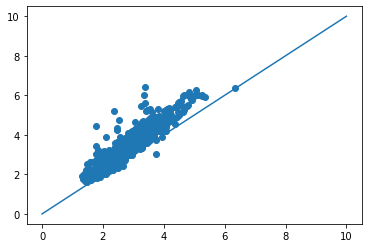

In [ ]:
plt.scatter(matches['int_tar']/2, matches['int_pred'])
print(np.round(np.linalg.lstsq(matches['int_tar'].values.reshape(-1,1)/2, matches['int_pred'].values, rcond=None)[0][0],2))
plt.plot([0,10],[0,10])

(array([20., 29., 44., 31., 28., 14.,  8.,  9.,  3.,  1.]),
 array([1.136148 , 1.5010501, 1.8659523, 2.2308543, 2.5957565, 2.9606586,
        3.3255606, 3.6904628, 4.055365 , 4.420267 , 4.785169 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

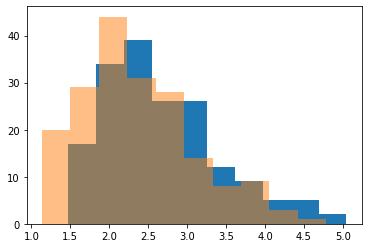

In [ ]:
plt.hist(gt_df['int']/2)
plt.hist(dec_df_col['int'], alpha=0.5)

Recall: 0.992
Precision: 0.995
Jaccard: 98.663
RMSE_vol: 27.913
Eff_3d: 85.980
FN: 9.0 FP: 6.0
Shift: -1.32,-0.21,0.14


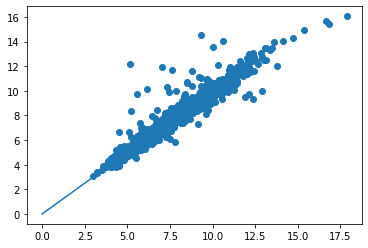

In [ ]:
xsim, gt = sim_data(decode_dl, 10, micro)
perf, pred_df, matches = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

plt.scatter(matches['int_tar'], matches['int_pred'])
plt.plot([0,10],[0,10])

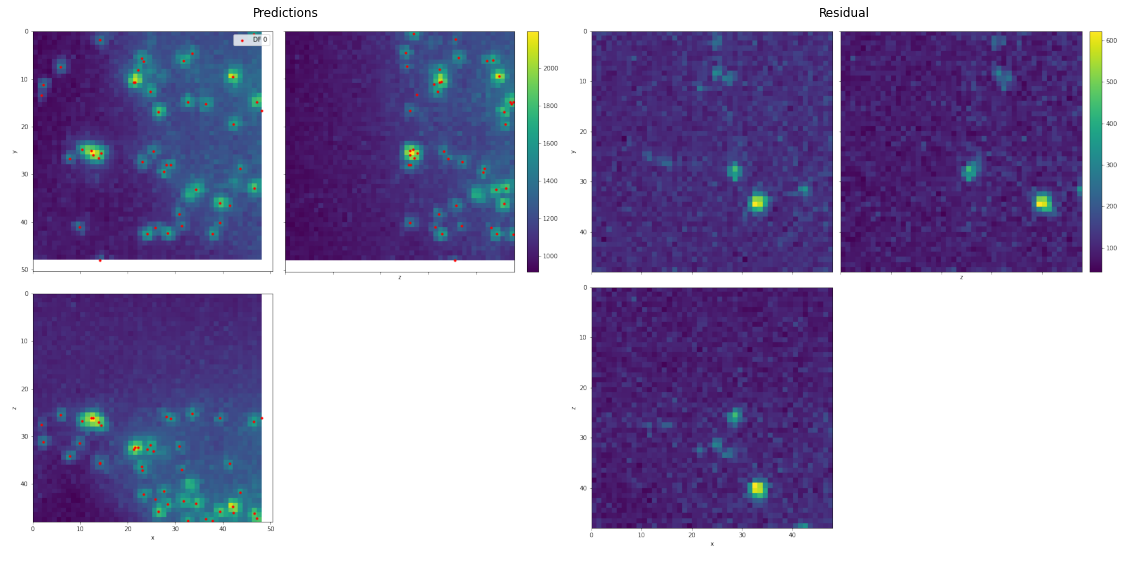

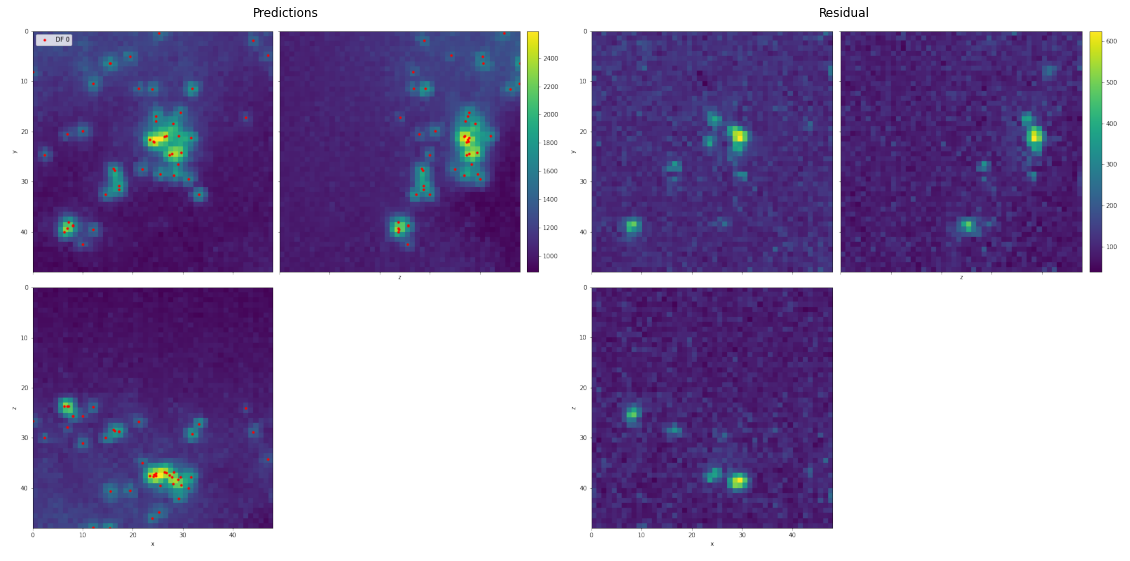

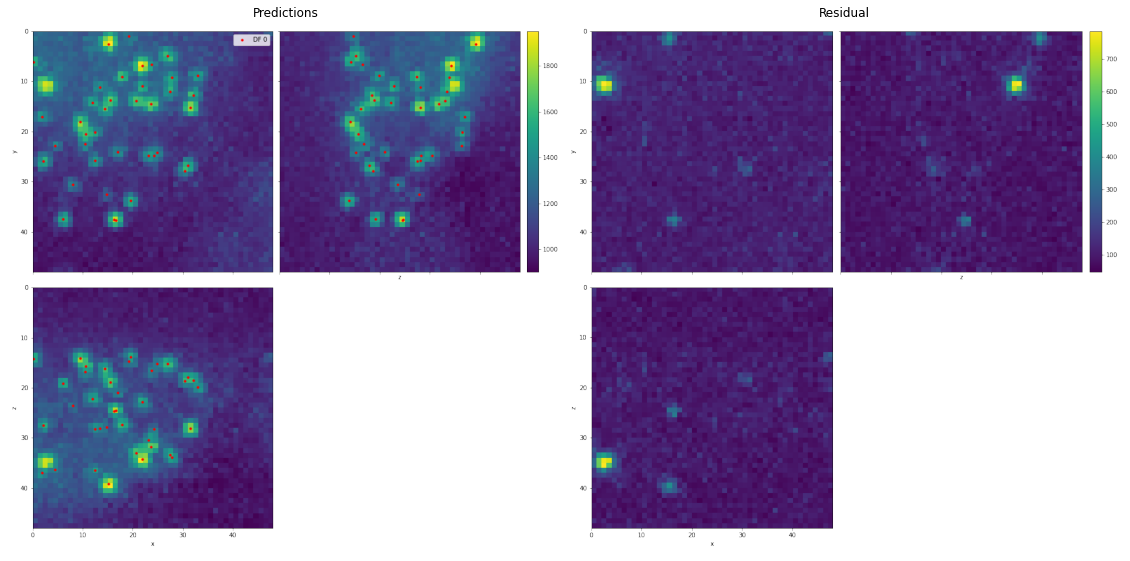

In [ ]:
eval_random_crop(decode_dl, model, post_proc, micro, proj_func=np.max, samples=3, int_threshold=1000)

In [ ]:
# eval_random_sim(decode_dl, model, post_proc, micro, proj_func=np.max, samples=3)

In [ ]:
from decode_fish.funcs.fit_psf import get_peaks_3d
from decode_fish.funcs.fit_psf import plot_detection
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1/'

files = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig8_int2/*/train.yaml'))

dec_count_col = []
dec_ints_col = []
prob_sum_col = []

dec_int_col = []

names = []

for f in files:
    
    print(f)
        
    cfg = OmegaConf.load(f)
    names.append(str(Path(f).parent).split('/')[-1])
#     model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)
    model = hydra.utils.instantiate(cfg.model)
    post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
    model = load_model_state(model, Path(cfg.output.save_dir)/'model.pkl')
    _ = model.cuda()

    box_sz = 10
    n_cells = 20
    gt_counts = []
    fq_counts = []
    dec_counts = []
    prob_sums = []
    
    gt_ints = []
    fq_ints = []
    dec_ints = []

    for i in tqdm(range(n_cells)):

        img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', i)
        gt_px = nm_to_px(gt_df, px_size_zyx=[300,100,100])
        fq_px = nm_to_px(fq_gmm_df, px_size_zyx=[300,100,100])
        with torch.no_grad():
            res_dict = model.tensor_to_dict(model(img[None].cuda()))
            dec_df = shift_df(post_proc.get_df(res_dict), [-100,-100,-300])
            free_mem()
        dec_px = nm_to_px(dec_df, px_size_zyx=[300,100,100])

        try:
            coords_xyz = get_peaks_3d(img[0], threshold=2000, min_distance=10)
        except AssertionError:
            continue
        coords_zyx = coords_xyz[:,::-1]

        for c in coords_zyx:
            sl = np.s_[:,c[0]-box_sz:c[0]+box_sz+1, c[1]-box_sz:c[1]+box_sz+1, c[2]-box_sz:c[2]+box_sz+1]
            gt_crop = crop_df(gt_px, sl)
            fq_crop = crop_df(fq_px, sl)
            dec_crop = crop_df(dec_px, sl)
            prob_crop = torch.sigmoid(res_dict['logits'])[0][sl]
            
            if len(gt_crop) < 50:

                gt_counts.append(len(gt_crop))
                fq_counts.append(len(fq_crop))
                dec_counts.append(len(dec_crop))

                dec_ints.append(dec_crop['int'].values)

                prob_sums.append(prob_crop.sum().item())

                dec_int_col.append(dec_crop['int'].values)
            
    dec_count_col.append(dec_counts)
    prob_sum_col.append(prob_sums)

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig8_int2/int_loc:0xenabled:False/train.yaml


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig8_int2/int_loc:0xenabled:True/train.yaml


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig8_int2/int_loc:1.5xenabled:False/train.yaml


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig8_int2/int_loc:1.5xenabled:True/train.yaml


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig8_int2/int_loc:3xenabled:False/train.yaml


100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig8_int2/int_loc:3xenabled:True/train.yaml


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig8_int2/int_loc:4.5xenabled:False/train.yaml


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_fig8_int2/int_loc:4.5xenabled:True/train.yaml


100%|██████████| 20/20 [00:20<00:00,  1.00s/it]


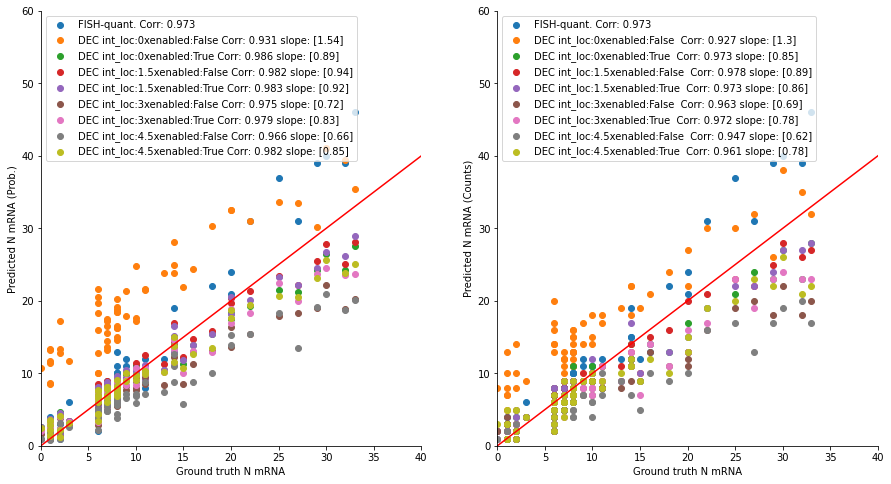

In [ ]:
plt.figure(figsize=(15,8))
import seaborn as sns

plt.subplot(121)
corr = np.round(np.corrcoef([gt_counts, fq_counts])[0,1],3)
plt.scatter(gt_counts, fq_counts, label=f'FISH-quant. Corr: {corr}')
for i,c in enumerate(prob_sum_col):
    corr = np.round(np.corrcoef([gt_counts, c])[0,1],3)
    slope = np.round(np.linalg.lstsq(np.array(gt_counts)[:,None], np.array(c)[:,None] ,rcond=None)[0][0],2)
    plt.scatter(gt_counts, c, label=f'DEC {names[i]} Corr: {corr} slope: {slope}', alpha=1.0)
    
plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA (Prob.)')
plt.xlim(0,40)
plt.ylim(0,60)
plt.legend()
sns.despine()

plt.subplot(122)
corr = np.round(np.corrcoef([gt_counts, fq_counts])[0,1],3)
plt.scatter(gt_counts, fq_counts, label=f'FISH-quant. Corr: {corr}')

for i,c in enumerate(dec_count_col):
    corr = np.round(np.corrcoef([gt_counts, c])[0,1],3)
    slope = np.round(np.linalg.lstsq(np.array(gt_counts)[:,None], np.array(c)[:,None] ,rcond=None)[0][0],2)
    plt.scatter(gt_counts, c, label=f'DEC {names[i]}  Corr: {corr} slope: {slope}', alpha=1.0)

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA (Counts)')
plt.xlim(0,40)
plt.ylim(0,60)

plt.legend()
sns.despine()
# print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])

(array([0.04771959, 0.29824755, 0.57661177, 0.6402379 , 0.43742962,
        0.20678491, 0.05964949, 0.01988318, 0.01192989, 0.00795327]),
 array([1.180745 , 1.6143123, 2.0478795, 2.4814467, 2.915014 , 3.3485813,
        3.7821486, 4.215716 , 4.649283 , 5.0828505, 5.5164175],
       dtype=float32),
 <BarContainer object of 10 artists>)

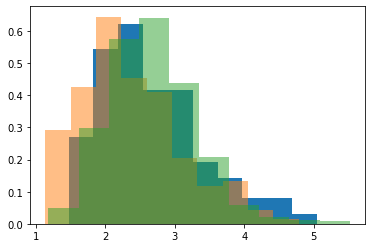

In [ ]:
plt.hist(gt_df['int']/2, density=True)
plt.hist(dec_df_col['int'], alpha=0.5, density=True)
plt.hist(tra, density=True, alpha=0.5)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted hyper.ipynb.
Converted index.ipynb.
